# **SBI: In-class exercise**

In [2]:
# --- Compatibility patch for GetDist + NumPy 2.0 ---
# NumPy 2.0 removed np.infty, but older versions of GetDist still use it.
# This patch restores it at runtime before importing GetDist.

import numpy as np
if not hasattr(np, 'infty'):
    np.infty = np.inf  # Restore deprecated alias for compatibility

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
import emcee
from scipy.stats import poisson
from scipy.stats import chi2
from scipy.optimize import basinhopping
from tqdm import tqdm
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from scipy.stats import norm
from getdist import plots, MCSamples
from scipy.integrate import quad
import multiprocessing
from multiprocessing import Pool

In [4]:
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

In [5]:
%matplotlib inline

## Introduction

In the main notebook, our mock observations were generated by simply <span style="color:darkorange">adding some Gaussian noise to the theoretical data</span>. However, in a <span style="color:darkorange">real experiment</span>, our observations may be affected various <span style="color:darkorange">other effects</span>, which may be caused by the instruments, the environment, physical processes, etc. These effects are often very **hard to model with a simple analytical function**, and may introduce additional **biases** in the data.

In this exercise, we will assume that our observations are contaminated by two new effects: random instrumental drift and intermittent calibration errors.

1. **Random instrumental drift**: The instrument that we use to measure the data is not perfect, and its <span style="color:darkorange">calibration may drift over time</span> due to environmental factors or aging hardware. This drift will accumulate over time and so the measurements that we take at different times may be affected by a random offset. We can model this effect by adding a cumulative sum of normally distributed random values to the true magnitudes.
    <details> 
    <summary>Why? <br><br>
    </summary>
    This simulates the effect of a drift that changes the measurements in a continuous but random manner. The random values are drawn from a normal distribution with a mean of zero, ensuring that the drift can go in either direction (positive or negative) and has a variance that reflects the magnitude of the drift per observation.
    <br> <br>
    </details>


2. **Intermittent calibration errors**: The instrument may also suffer from occasional <span style="color:darkorange">large calibration errors</span> that occur at random intervals. This may be caused by a variety of factors, such as power surges, cosmic rays, mechanical disturbances, miscalibrations during the data collection process etc. We model these errors by introducing occasional large spikes in the observed magnitudes.

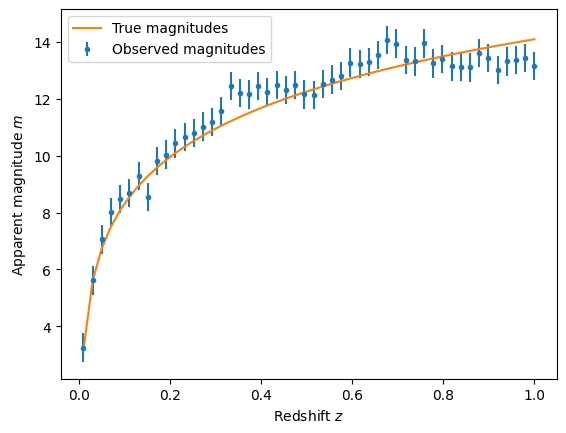

In [6]:
#random seed
np.random.seed(1235)
torch.manual_seed(1234)

# Constants
c = 299792.458  # Speed of light in km/s

# True cosmological parameters
true_Omega_m = 0.3
true_H0 = 70.0  # Hubble constant in km/s/Mpc

# Redshifts of the supernovae
z = np.linspace(0.01, 1.0, 50)

# Noise level in the observed magnitudes
sigma = 0.1

# Luminosity distance function
def luminosity_distance(z, Omega_m, H0):
    """ Calculate the luminosity distance for a given redshift, Omega_m and H0 """
    integrand = lambda z_prime: 1.0 / np.sqrt(Omega_m * (1 + z_prime)**3 + (1 - Omega_m))
    d_L = np.array([quad(integrand, 0, z_i)[0] for z_i in z])
    return (c * (1 + z) * d_L) / H0

# Generate synthetic data
# Generate synthetic data with non-linear transformation
d_L_true = luminosity_distance(z, true_Omega_m, true_H0)
m_true = 5 * np.log10(d_L_true / 10)

# Introduce random walk drift
def random_walk_drift(m, z):
    drift = np.cumsum(np.random.normal(0, 0.2, len(m)))
    return m + drift

# Introduce intermittent calibration errors
def intermittent_calibration_errors(m, z):
    errors = np.zeros_like(m)
    error_indices = np.random.choice(len(m), size=int(len(m) * 0.1), replace=False)
    errors[error_indices] = np.random.normal(0, 1, len(error_indices))
    return m + errors

# Apply both effects to the observed magnitudes
m_obs_drift = random_walk_drift(m_true, z)
m_obs = intermittent_calibration_errors(m_obs_drift, z) + np.random.normal(0, sigma, len(m_true))


# Plot synthetic data
plt.errorbar(z, m_obs, yerr=0.5, fmt='.', label='Observed magnitudes')
plt.plot(z, m_true, label='True magnitudes')
plt.xlabel('Redshift $z$')
plt.ylabel('Apparent magnitude $m$')
plt.legend()
plt.show()


<div class="alert alert-block alert-warning" style="margin-top: 20px">

# Part 1: Solving with Gaussian likelihood

**Problem:** Given the observed magnitudes $m_{\text{obs}}$ and redshifts $z$, infer the cosmological parameters $\Omega_m$ and $H_0$ using the traditional Bayesian approach assuming a Gaussian likelihood.

**Tasks:**
1. Define the prior, a Gaussian likelihood with some $\sigma$ and the posterior.
2. Run MCMC to sample from the posterior.
3. Plot the corner plot of the posterior samples and see if the results are consistent with the true values.

</div>

<div class="alert alert-danger alertdanger" style="margin-top: 20px">

<details>
    <summary><b>Click to see the tip</b></summary>
    
Do ***exactly*** what was done in the main notebook:

- For the prior, use a flat prior over $\Omega_m$ and $H_0$.
- For the Gaussian likelihood, you can assume a $\sigma$ looking at the data (I would assume $\sigma=0.5$, as in the main notebook).
- For MCMC, you can use the `emcee` package.
    
</details>

</div>

Task 1:

In [7]:
# Log-prior function
def log_prior(params):
    Omega_m, H0 = params
    if 0 < Omega_m < 1 and 50 < H0 < 100:
        return 0
    else:
        return -np.inf
    
# Define the log-likelihood function
def log_like(params, z, m_obs):
    Omega_m, H0 = params
    d_L = luminosity_distance(z, Omega_m, H0)
    m_th = 5 * np.log10(d_L / 10)
    sigma_m = 0.5  # Assumed standard deviation of magnitudes
    return -0.5 * np.sum(((m_obs - m_th) / sigma_m)**2)    

# Log-posterior function
def log_post(params, z, m_obs):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_like(params, z, m_obs)

Task 2:

In [8]:
# Sampling with `emcee` 
ndim, nwalkers = 2, 16
ncpus = multiprocessing.cpu_count()

# Initialize walkers around a random position withing the prior volume
pos = np.random.uniform([0, 50], [1, 100], (nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(z, m_obs))
sampler.run_mcmc(pos, 2000, progress=True)

  0%|          | 5/2000 [00:00<00:41, 48.51it/s]

100%|██████████| 2000/2000 [00:35<00:00, 56.46it/s]


State([[ 0.88416249 55.22244537]
 [ 0.58263633 57.58860531]
 [ 0.62382084 58.84251957]
 [ 0.42983529 62.59658314]
 [ 0.39639924 62.82043164]
 [ 0.5096167  61.26381511]
 [ 0.4104348  62.33628852]
 [ 0.81129606 58.31119545]
 [ 0.98622173 53.35682512]
 [ 0.97548035 53.86178692]
 [ 0.62494787 58.58359683]
 [ 0.88492404 57.31184126]
 [ 0.98737632 55.91081678]
 [ 0.97401781 54.31562813]
 [ 0.7767411  56.96262491]
 [ 0.67750643 59.11298303]], log_prob=[-20.60396191 -22.06243285 -21.00579054 -22.11617002 -22.47543393
 -21.49949702 -22.36931184 -20.63846701 -20.97957911 -20.75748426
 -21.06329873 -20.53925403 -20.46375149 -20.57597516 -20.57806881
 -20.74029136], blobs=None, random_state=('MT19937', array([3918475373,  166398576, 1880061081, 3187825935, 3721248299,
        939909199, 1388204918,  863223978, 2583232908, 1632754433,
       3508643875,  929374050, 1312140065,  125620301, 1316580093,
        146270485, 3579588618,  888199230, 1932262001,  157323764,
       1392639056, 2000931167, 2

Task 3:

<>:5: SyntaxWarning: invalid escape sequence '\O'
<>:5: SyntaxWarning: invalid escape sequence '\O'
<>:7: SyntaxWarning: invalid escape sequence '\O'
<>:5: SyntaxWarning: invalid escape sequence '\O'
<>:5: SyntaxWarning: invalid escape sequence '\O'
<>:7: SyntaxWarning: invalid escape sequence '\O'
/tmp/ipykernel_2557366/2845518695.py:5: SyntaxWarning: invalid escape sequence '\O'
  samples = MCSamples(samples=flat_samples, names=['\Omega_m', 'H_0'], labels=['\Omega_m', 'H_0'])
/tmp/ipykernel_2557366/2845518695.py:5: SyntaxWarning: invalid escape sequence '\O'
  samples = MCSamples(samples=flat_samples, names=['\Omega_m', 'H_0'], labels=['\Omega_m', 'H_0'])
/tmp/ipykernel_2557366/2845518695.py:7: SyntaxWarning: invalid escape sequence '\O'
  g.triangle_plot(samples, filled=True, markers={'\Omega_m': true_Omega_m, 'H_0': true_H0})


Removed no burn in


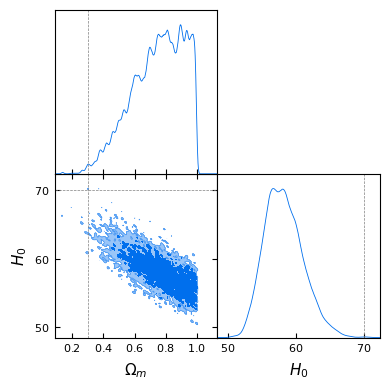

In [9]:
# Get samples and convert to GetDist MCSamples
flat_samples = sampler.get_chain(discard=1000, flat=True)

# GetDist plotting
samples = MCSamples(samples=flat_samples, names=['\Omega_m', 'H_0'], labels=['\Omega_m', 'H_0'])
g = plots.get_subplot_plotter(width_inch=4)
g.triangle_plot(samples, filled=True, markers={'\Omega_m': true_Omega_m, 'H_0': true_H0})
plt.show()

<div class="alert alert-block alert-warning" style="margin-top: 20px">

# Part 2: Solving with Neural Posterior Estimation

**Problem:** Given the observed magnitudes $m_{\text{obs}}$ and redshifts $z$, infer the cosmological parameters $\Omega_m$ and $H_0$ using the Neural Posterior Estimation approach.

**Tasks:**
1. Construct a **simulator** that generates the observed magnitudes $m_{\text{obs}}$ given the cosmological parameters $\Omega_m$ and $H_0$. Encode the random instrumental drifts and intermittent calibration errors in the simulator.
2. Generate a **training dataset** of observed magnitudes $m_{\text{obs}}$ and corresponding cosmological parameters $\Omega_m$ and $H_0$, by running the simulator for a range of randomly drawn parameters $\Omega_m$ and $H_0$. 
3. Define the **Neural Posterior Estimator** class that will use the feature extractor to estimate the posterior with a normalizing flow.
4. Sample from the NPE, conditioning on the observed magnitudes $m_{\text{obs}}$ that we had in the beginning.
5. Plot the corner plot of the posterior samples and see if the results are consistent with the true values.

</div>

<div class="alert alert-danger alertdanger" style="margin-top: 20px">

<details>
    <summary><b>Click to see the tip</b></summary>

Again, do ***exactly*** what was done in the main notebook. The actual changes that you need to implement are:
* In the simulator, introduce the random instrumental drifts and intermittent calibration errors.
* For the test data, use instead the observed magnitudes $m_{\text{obs}}$ that we showed in the beginning.

</details>

Task 1:

In [10]:
# Forward model to simulate observed magnitudes
def luminosity_distance_simulator(params, z):
    Omega_m, H0 = params
    d_L = luminosity_distance(z, Omega_m, H0)
    m_th = 5 * np.log10(d_L / 10)
    m_sim_drift = random_walk_drift(m_th, z)
    m_sim = intermittent_calibration_errors(m_sim_drift, z) + np.random.normal(0, sigma, len(m_th))

    return m_sim

Task 2:

In [11]:
np.random.seed(1234) # use random seed for reproducibility

# Generate training data
n_train = 50_000
param_samples = np.random.uniform(low=[0, 50], high=[1, 100], size=(n_train, 2)) # Parameter proposal
x_samples = np.array([luminosity_distance_simulator(theta, z) for theta in tqdm(param_samples)])

# Convert to tensors
param_samples = torch.tensor(param_samples, dtype=torch.float32)
x_samples = torch.tensor(x_samples, dtype=torch.float32)

100%|██████████| 50000/50000 [01:01<00:00, 816.94it/s]


In [22]:
import sbi
from sbi.inference import NPE

# Define the SBI model and simply feed it parameters theta and corresponding simulations x
inference = NPE()
inference.append_simulations(param_samples, x_samples).train()
posterior = inference.build_posterior()

2025-11-12 08:12:49.757676: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762935169.771549 2557366 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762935169.775780 2557366 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762935169.788187 2557366 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762935169.788202 2557366 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762935169.788204 2557366 computation_placer.cc:177] computation placer alr

 Neural network successfully converged after 55 epochs.

Nice, sample from the posterior distribution using the trained model, conditioned on the observed data $x_{\text{obs}}$, and make the corner plot of the posteriors:

<>:11: SyntaxWarning: invalid escape sequence '\O'
<>:11: SyntaxWarning: invalid escape sequence '\O'
<>:15: SyntaxWarning: invalid escape sequence '\O'
<>:11: SyntaxWarning: invalid escape sequence '\O'
<>:11: SyntaxWarning: invalid escape sequence '\O'
<>:15: SyntaxWarning: invalid escape sequence '\O'
/tmp/ipykernel_2557366/4261172519.py:11: SyntaxWarning: invalid escape sequence '\O'
  gd_samples_npe = MCSamples(samples=samples_npe, labels=['\Omega_m', 'H_0'], names=['\Omega_m', 'H_0'])
/tmp/ipykernel_2557366/4261172519.py:11: SyntaxWarning: invalid escape sequence '\O'
  gd_samples_npe = MCSamples(samples=samples_npe, labels=['\Omega_m', 'H_0'], names=['\Omega_m', 'H_0'])
/tmp/ipykernel_2557366/4261172519.py:15: SyntaxWarning: invalid escape sequence '\O'
  g.triangle_plot([gd_samples_npe, samples], filled=True, markers={'\Omega_m': true_Omega_m, 'H_0': true_H0}, legend_labels=['NPE', 'MCMC'])


  0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


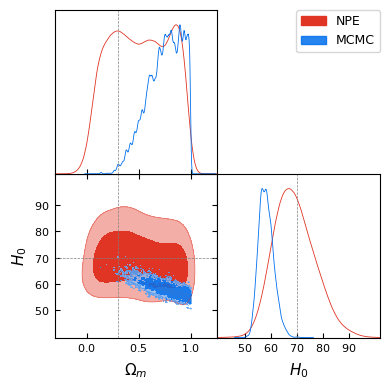

In [23]:
samples_npe = posterior.sample((10000,), x=m_obs)

# Convert to numpy (ensure on CPU and detached from graph)
if isinstance(samples_npe, torch.Tensor):
    samples_npe = samples_npe.detach().cpu().numpy()
else:
    samples_npe = np.asarray(samples)


# Create a getdist MCSamples object
gd_samples_npe = MCSamples(samples=samples_npe, labels=['\Omega_m', 'H_0'], names=['\Omega_m', 'H_0'])

# Make a triangle/contour plot with getdist
g = plots.get_subplot_plotter()
g.triangle_plot([gd_samples_npe, samples], filled=True, markers={'\Omega_m': true_Omega_m, 'H_0': true_H0}, legend_labels=['NPE', 'MCMC'])